In [1]:
import matplotlib.pyplot as plt
import glob
from pandas import read_csv
import os

In [2]:
def find_angle(f1, f2, D):
    #D = 2870 #In MHz
    gamma = 2.8 #In MHz/Gauss
    b_perp = np.sqrt(D * (f1+f2-2*D) / (3 * gamma**2))
    b_z = np.sqrt( ((f2-f1)/(2*gamma))**2 - ((f1+f2-2*D)/(6*gamma))**2)
    b = np.sqrt(b_perp**2 + b_z**2)
    theta = np.rad2deg(np.arccos(b_z/b))
    return b_perp, b_z, b, theta

In [3]:
def find_freq_bpbz(b_perp, b_z, D): # b_perp, b_z in gauss, D in MHz
    gamma = 2.8 #In MHz/Gauss
    detE = gamma**2*b_perp**2/D
    Ep_abs = gamma**2*b_perp**2/2/D
    freq1 = D+1.5*detE+np.sqrt(gamma**2*b_z**2+Ep_abs**2)
    freq2 = D+1.5*detE-np.sqrt(gamma**2*b_z**2+Ep_abs**2)
    return freq1, freq2

In [4]:
def find_freq_btheta(b, theta, D): # b in gauss, theta in degree, D in MHz
    gamma = 2.8 #In MHz/Gauss
    b_z = b*np.cos(theta/180*np.pi)
    b_perp = b*np.sin(theta/180*np.pi)
    detE = gamma**2*b_perp**2/D
    Ep_abs = gamma**2*b_perp**2/2/D
    freq1 = D+1.5*detE+np.sqrt(gamma**2*b_z**2+Ep_abs**2)
    freq2 = D+1.5*detE-np.sqrt(gamma**2*b_z**2+Ep_abs**2)
    return freq1, freq2

In [12]:
right_offset_list = [5]
left_offset_list = [0]

## Do double lorentz fit on split ODMR from auto ODMR compiled visually for NV pairs / triples

peak 1 2792330572.2097754, peak 2 2869018689.205268, peak 3 2921871194.1162047, peak 4 2988833514.7837367
b_perp_outer 11.959774222696128 b_z_outer 35.08974276043781 b_outer 37.07190643130677 theta_outer 18.820850871469403
b_perp_inner 36.57984626841774 b_z_inner 9.415661239949879 b_inner 37.77220975276096 theta_inner 75.56539536115507



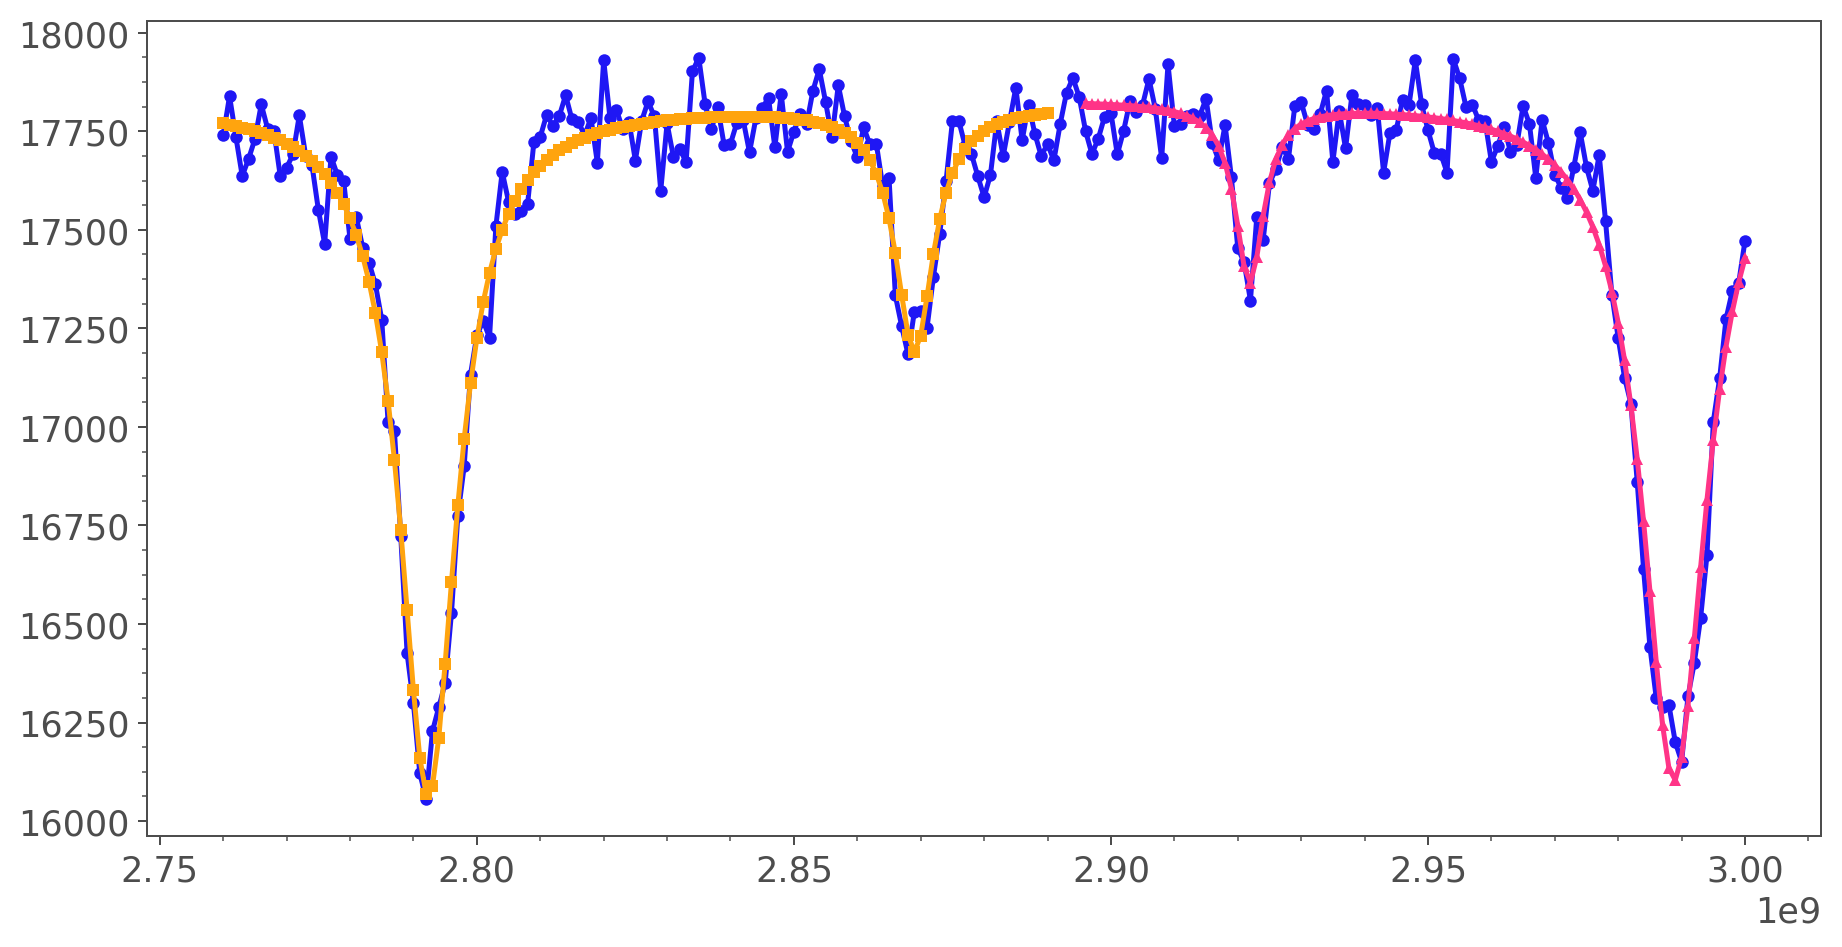

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-202-388b22e4411b>", line 2, in <module>
    plt.plot(t,arb_form_1)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\matplotlib\pyplot.py", line 3358, in plot
    ret = ax.plot(*args, **kwargs)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\matplotlib\__init__.py", line 1855, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\matplotlib\axes\_axes.py", line 1527, in plot
    for line in self._get_lines(*args, **kwargs):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\matplotlib\axes\_base.py", line 406, in _grab_next_args
    for seg in self._plot_args(this, kwargs):
  File "C:\Users\PI3\anaconda3\envs\qudi\lib\site-packages\matplotlib\axes\_base.py", line 383, in _plot_args
    x, y = self._xy_from_xy(x, y)
  Fil

In [36]:
dir_ = 'C:/Users/PI3/Desktop/b alignment odmr 1028/'
nNV = 2
D = 2890
for i, file in enumerate(os.listdir(dir_)):
#     if i:
#         nNV = 2
#     else:
#         nNV = 3
    data = read_csv(dir_ + file, skiprows=0, header=None, delimiter='\t', names=['x','y'])
    x = np.asarray(data['x'])
    y = np.asarray(data['y'])
    
    split = list(np.where(np.abs(x-2.89e9)<=100e4))[0][-1]
    right_offset= right_offset_list[i]
    left_offset= left_offset_list[i]
    x_left = x[:split-left_offset]
    y_left = y[:split-left_offset]
    x_right = x[split+right_offset:]
    y_right = y[split+right_offset:]
    if nNV == 3:
        x_middle = x[split-left_offset:split+right_offset]
        y_middle = y[split-left_offset:split+right_offset]
    
    result_left = fitlogic.make_lorentziandouble_fit(x_axis=x_left, data=y_left, estimator=fitlogic.estimate_lorentziandouble_dip)
    #result_right = fitlogic.make_lorentziandouble_fit(x_axis=x_right, data=y_right, estimator=fitlogic.estimate_lorentziandouble_dip)
    result_right = fitlogic.make_lorentziandouble_fit(x_axis=x_right, data=y_right, estimator=estimator_funky)
    if nNV == 3:
        result_middle = fitlogic.make_lorentziandouble_fit(x_axis=x_middle, data=y_middle, estimator=fitlogic.estimate_lorentziandouble_dip)
    
    plt.plot(x,y)
    plt.plot(x_left,result_left.best_fit)
    plt.plot(x_right,result_right.best_fit)
    if nNV == 3:
        plt.plot(x_middle,result_middle.best_fit)

    peak1=result_left.params['l0_center'].value
    peak2=result_left.params['l1_center'].value
    peak3=result_right.params['l0_center'].value
    peak4=result_right.params['l1_center'].value
    if nNV == 3:
        peak3=result_middle.params['l0_center'].value
        peak4=result_middle.params['l1_center'].value
        peak5=result_right.params['l0_center'].value
        peak6=result_right.params['l1_center'].value
    
    if nNV == 3:
        b_perp_outer, b_z_outer, b_outer, theta_outer = find_angle(peak1*10**-6, peak6*10**-6, D)
        b_perp_midd, b_z_midd, b_midd, theta_midd = find_angle(peak2*10**-6, peak5*10**-6, D)
        b_perp_inner, b_z_inner, b_inner, theta_inner = find_angle(peak3*10**-6, peak4*10**-6, D)
        print(f'peak 1 {peak1}, peak 2 {peak2}, peak 3 {peak3}, peak 4 {peak4}, peak 5 {peak5}, peak 6 {peak6}')
        print(f'b_perp_outer {b_perp_outer} b_z_outer {b_z_outer} b_outer {b_outer} theta_outer {theta_outer}')
        print(f'b_perp_midd {b_perp_midd} b_z_midd {b_z_midd} b_midd {b_midd} theta_midd {theta_midd}')
        print(f'b_perp_inner {b_perp_inner} b_z_inner {b_z_inner} b_inner {b_inner} theta_inner {theta_inner}\n')
    else:
        b_perp_outer, b_z_outer, b_outer, theta_outer = find_angle(peak1*10**-6, peak4*10**-6, D)
        b_perp_inner, b_z_inner, b_inner, theta_inner = find_angle(peak2*10**-6, peak3*10**-6, D)
        print(f'peak 1 {peak1}, peak 2 {peak2}, peak 3 {peak3}, peak 4 {peak4}')
        print(f'b_perp_outer {b_perp_outer} b_z_outer {b_z_outer} b_outer {b_outer} theta_outer {theta_outer}')
        print(f'b_perp_inner {b_perp_inner} b_z_inner {b_z_inner} b_inner {b_inner} theta_inner {theta_inner}\n')
    plt.show()

In [24]:
params =  result_right.params

In [9]:
peak 1 2760180466.0455737, peak 2 2833409961.581182, peak 3 2921180595.3832006, peak 4 2981164485.387427

In [35]:
def estimator_funky(x_right, y_right, params):
    return fitlogic.estimate_lorentziandouble_dip(x_right,
                                        data=y_right,
                                       params=params,
                                       threshold_fraction=0.03,
                                        minimal_threshold=0.001,
                                        sigma_threshold_fraction=0.03)

In [118]:
find_angle(2810, 2942)

(38.26598638851107, 23.560603574958062, 44.93759845721666, 58.37913691780499)

In [113]:
find_angle(2873, 2882)

(nan, 41.05417166790567, nan, nan)

In [114]:
2745+2975-2*2870

-20

In [97]:
find_freq_bpbz(42.782673395396216, 16.22545241657221, 2870)

(2923.0, 2832.0)

In [111]:
find_freq_btheta(41.75611925174154, 10, 2860)

(2975.35710571209, 2745.0752607536006)

peak 1 2758209339.628358, peak 2 2760359339.628358, peak 3 2806960794.8104987, peak 4 2809110794.8104987
b_perp_outer nan b_z_outer nan b_outer nan theta_outer nan
b_perp_inner nan b_z_inner nan b_inner nan theta_inner nan



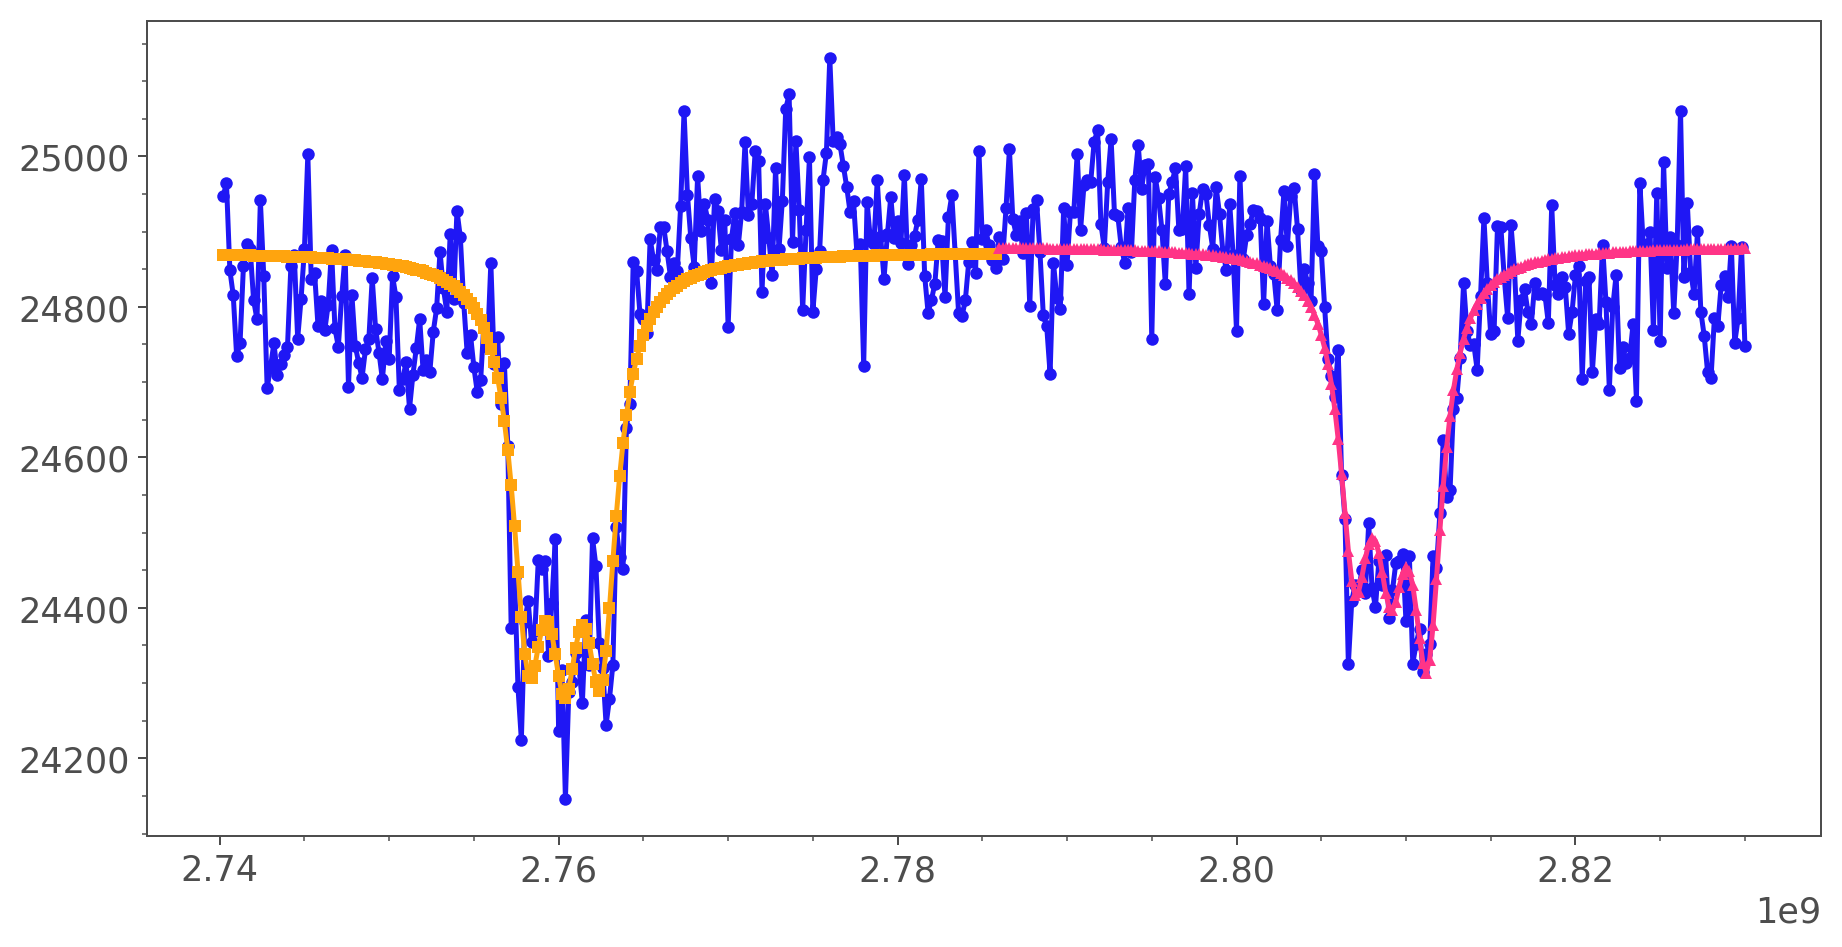

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-76-20beeaddbc20>", line 5, in <module>
    microwave_2._gpib_connection.write(':DM:DList' +user_list)
TypeError: must be str, not set
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-1a297c9fabaf>", line 4, in <module>
    microwave_2._gpib_connection.write(':DM:DList' +user_list)
TypeError: must be str, not set
Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-1a297c9fabaf>", line 4, in <module>
    microwave_2._gpib_connection.write(':DM:DList' +user_list)
TypeError: must be str, not set
Traceback (most recent ca

In [16]:
right_offset_list = [0]
left_offset_list = [0]
peakcenter = 2.785e9
i = 0
dir_ = 'C:/Data/2020/10/20201006/ODMR/'
file = '20201006-1442-29_site_1_11_14_podmr_m12dBm_pi400ns_MW1_ODMR_data_ch0.dat'
data = read_csv(dir_ + file, skiprows=20, header=None, delimiter='\t', names=['x','y'])
x = np.asarray(data['x'])
y = np.asarray(data['y'])

split = list(np.where(np.abs(x-peakcenter)<=100e4))[0][-1]
right_offset= right_offset_list[i]
left_offset= left_offset_list[i]
x_left = x[:split-left_offset]
y_left = y[:split-left_offset]
x_right = x[split+right_offset:]
y_right = y[split+right_offset:]

#result_left = fitlogic.make_lorentziandouble_fit(x_axis=x_left, data=y_left, estimator=fitlogic.estimate_lorentziandouble_dip)
#result_right = fitlogic.make_lorentziandouble_fit(x_axis=x_right, data=y_right, estimator=fitlogic.estimate_lorentziandouble_dip)
result_left = fitlogic.make_lorentziantriple_fit(x_axis=x_left, data=y_left, estimator=fitlogic.estimate_lorentziantriple_N14)
result_right = fitlogic.make_lorentziantriple_fit(x_axis=x_right, data=y_right, estimator=fitlogic.estimate_lorentziantriple_N14)

plt.plot(x,y)
plt.plot(x_left,result_left.best_fit)
plt.plot(x_right,result_right.best_fit)

peak1=result_left.params['l0_center'].value
peak2=result_left.params['l1_center'].value
peak3=result_right.params['l0_center'].value
peak4=result_right.params['l1_center'].value

b_perp_outer, b_z_outer, b_outer, theta_outer = find_angle(peak1*10**-6, peak4*10**-6)
b_perp_inner, b_z_inner, b_inner, theta_inner = find_angle(peak2*10**-6, peak3*10**-6)

print(f'peak 1 {peak1}, peak 2 {peak2}, peak 3 {peak3}, peak 4 {peak4}')
print(f'b_perp_outer {b_perp_outer} b_z_outer {b_z_outer} b_outer {b_outer} theta_outer {theta_outer}')
print(f'b_perp_inner {b_perp_inner} b_z_inner {b_z_inner} b_inner {b_inner} theta_inner {theta_inner}\n')
plt.show()